In [1]:
#!pip install celery

In [2]:
#!sudo rabbitmqctl add_user myguest myguestpwd
#!sudo rabbitmqctl set_permissions -p / myguest "." "." ".*"

In [3]:
!sudo rabbitmqctl list_users

Listing users ...
guest	[administrator]
myguest	[]


In [4]:
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import json

from sklearn.datasets import make_blobs
from copy import deepcopy

from celery import group
from kmeans_workers_v2 import kmeans_tasks, dist, NumpyEncoder


In [5]:
n_samples=1600
n_clusters=3
n_features =2
n_workers = 4 #Check the celery also uses 4 workers!!!

In [6]:
# Creating a n_features=2 Dim dataset with centers=3 clusters
Xs, Ys = make_blobs(n_samples=n_samples, n_features=n_features, centers=n_clusters, shuffle =False)

In [7]:
Ys

array([0, 0, 0, ..., 2, 2, 2])

In [8]:
mydata= [{"points": x, "label": y} for x,y in zip(Xs,Ys)]

In [9]:
print(len(mydata))
print(mydata[15]['points'],mydata[15]['label'])

1600
[-0.09558867  0.43992508] 0


In [10]:
# Split the sequence in a number of chunks and process those independently.

if 0:
    l = n_samples // n_workers
    Xsubseqs = [mydata[i * l:(i + 1) * l] for i in range(n_workers - 1)]
    Xsubseqs.append(mydata[(n_workers - 1) * l:])
else:
    splitting_points=[100,300,1000]
    Xsubseqs=[]
    Xsubseqs.append(mydata[0:splitting_points[0]])
    Xsubseqs.append(mydata[splitting_points[0]:splitting_points[1]])
    Xsubseqs.append(mydata[splitting_points[1]:splitting_points[2]])
    Xsubseqs.append(mydata[splitting_points[2]:])
    
    for i in range(4):
        print(len(Xsubseqs[i]))

100
200
700
600


In [11]:
np.matrix(np.diag(np.max(Xs,0)))

matrix([[5.80553573, 0.        ],
        [0.        , 8.31283802]])

In [12]:
C=np.matrix(np.random.rand(n_clusters,n_features))*np.matrix(np.diag(np.max(Xs,0)))
print("Initial Centroids")
print(C)


Initial Centroids
[[0.92176965 3.41172307]
 [2.61704481 3.23625747]
 [5.10521183 3.78862625]]


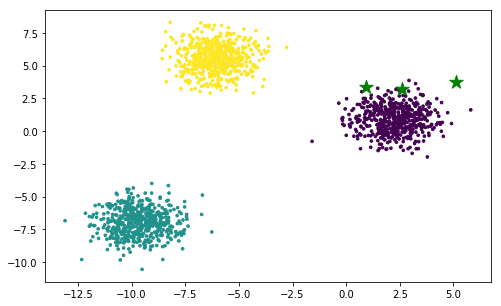

In [13]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 5)
fig = plt.figure()

# Plotting along with the Centroids
#plt.scatter([actdata.points[0] for actdata in mydata], [actdata.points[1] for actdata in mydata])
plt.scatter([actdata['points'][0] for actdata in mydata], [actdata['points'][1] for actdata in mydata],c=[actdata['label'] for actdata in mydata], s=7)

plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=200, c='g')


In [14]:
len([actdata['label'] for actdata in mydata])

1600

In [15]:
print(C)
print(C.shape)

[[0.92176965 3.41172307]
 [2.61704481 3.23625747]
 [5.10521183 3.78862625]]
(3, 2)


### Distributed Kmeans

In [16]:
C=np.matrix(np.random.rand(n_clusters,n_features))*np.matrix(np.diag(np.max(Xs,0)))
print("Initial Centroids")
print(C)

Initial Centroids
[[0.06199505 1.63439587]
 [3.72908987 0.25234362]
 [1.03703761 4.75398617]]


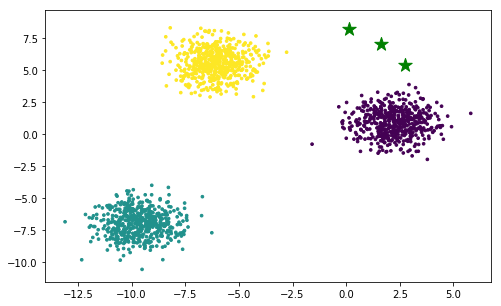

In [17]:
# Split the sequence in a number of chunks and process those independently.
n_workers = 4
n_iter =15

l = n_samples // n_workers
Xsubseqs = [mydata[i * l:(i + 1) * l] for i in range(n_workers - 1)]
Xsubseqs.append(mydata[(n_workers - 1) * l:])
C=np.matrix(np.random.rand(n_clusters,n_features))*np.matrix(np.diag(np.max(Xs,0)))

#plt.scatter([actdata.points[0] for actdata in mydata], [actdata.points[1] for actdata in mydata],c='#050505', s=7)
plt.scatter([actdata['points'][0] for actdata in mydata], [actdata['points'][1] for actdata in mydata],c=[actdata['label'] for actdata in mydata], s=7)
plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=200, c='g')


In [18]:
#Let us upload data to the workers
response = group(kmeans_tasks.s(task='data_to_workers', json_dump = json.dumps({'C': C, 'X': seq,'n_clusters': n_clusters, 'n_features':n_features}, cls=NumpyEncoder)) 
                                               for seq in Xsubseqs)() 

response.get()

['success', 'success', 'success', 'success']

[[[2.2640216007816516, 0.9474185224592113], [0.0, 0.0], [0.0, 0.0]], [[-5.737059121752088, -4.333419929844823], [0.0, 0.0], [0.0, 0.0]], [[-9.566913978231616, -6.9538660408397135], [0.0, 0.0], [-6.007590994342909, 5.66696999840142]], [[0.0, 0.0], [0.0, 0.0], [-6.061279400200972, 5.528847856450437]]]
[[400, 0, 0], [400, 0, 0], [267, 0, 133], [0, 0, 400]]
num_points in clusters: [1067    0  533]


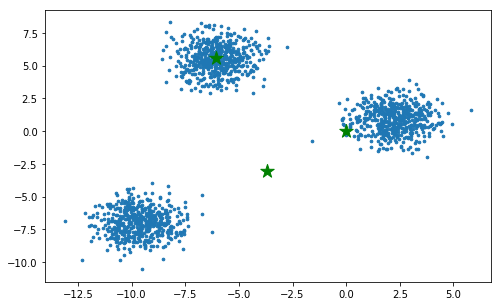

[[[0.0, 0.0], [2.2640216007816516, 0.9474185224592113], [0.0, 0.0]], [[-9.72752689276062, -6.937018391038619], [2.1843171998021793, 0.8349173140174869], [0.0, 0.0]], [[-9.566913978231616, -6.9538660408397135], [0.0, 0.0], [-6.007590994342909, 5.66696999840142]], [[0.0, 0.0], [0.0, 0.0], [-6.061279400200972, 5.528847856450437]]]
[[0, 400, 0], [266, 134, 0], [267, 0, 133], [0, 0, 400]]
num_points in clusters: [533 534 533]


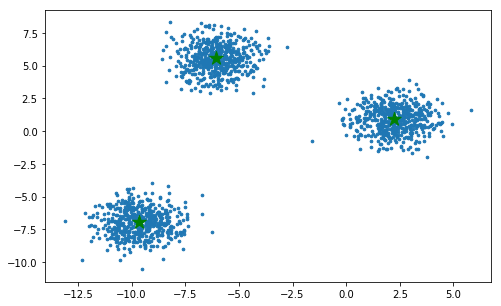

[[[0.0, 0.0], [2.2640216007816516, 0.9474185224592113], [0.0, 0.0]], [[-9.72752689276062, -6.937018391038619], [2.1843171998021793, 0.8349173140174869], [0.0, 0.0]], [[-9.566913978231616, -6.9538660408397135], [0.0, 0.0], [-6.007590994342909, 5.66696999840142]], [[0.0, 0.0], [0.0, 0.0], [-6.061279400200972, 5.528847856450437]]]
[[0, 400, 0], [266, 134, 0], [267, 0, 133], [0, 0, 400]]
num_points in clusters: [533 534 533]


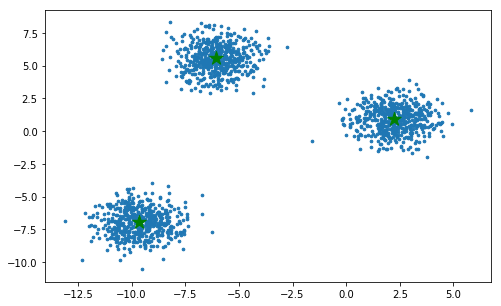

[[[0.0, 0.0], [2.2640216007816516, 0.9474185224592113], [0.0, 0.0]], [[-9.72752689276062, -6.937018391038619], [2.1843171998021793, 0.8349173140174869], [0.0, 0.0]], [[0.0, 0.0], [0.0, 0.0], [-6.061279400200972, 5.528847856450437]], [[-9.566913978231616, -6.9538660408397135], [0.0, 0.0], [-6.007590994342909, 5.66696999840142]]]
[[0, 400, 0], [266, 134, 0], [0, 0, 400], [267, 0, 133]]
num_points in clusters: [533 534 533]


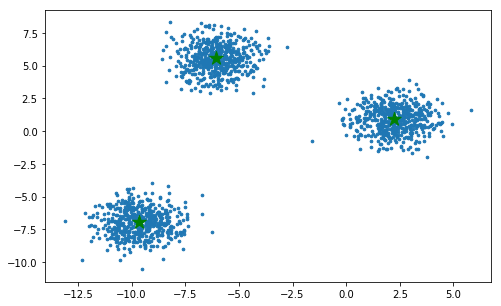

[[[0.0, 0.0], [0.0, 0.0], [-6.061279400200972, 5.528847856450437]], [[0.0, 0.0], [2.2640216007816516, 0.9474185224592113], [0.0, 0.0]], [[-9.72752689276062, -6.937018391038619], [2.1843171998021793, 0.8349173140174869], [0.0, 0.0]], [[-9.566913978231616, -6.9538660408397135], [0.0, 0.0], [-6.007590994342909, 5.66696999840142]]]
[[0, 0, 400], [0, 400, 0], [266, 134, 0], [267, 0, 133]]
num_points in clusters: [533 534 533]


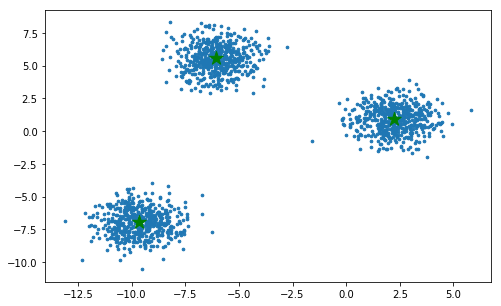

[[[0.0, 0.0], [0.0, 0.0], [-6.061279400200972, 5.528847856450437]], [[0.0, 0.0], [2.2640216007816516, 0.9474185224592113], [0.0, 0.0]], [[-9.72752689276062, -6.937018391038619], [2.1843171998021793, 0.8349173140174869], [0.0, 0.0]], [[-9.566913978231616, -6.9538660408397135], [0.0, 0.0], [-6.007590994342909, 5.66696999840142]]]
[[0, 0, 400], [0, 400, 0], [266, 134, 0], [267, 0, 133]]
num_points in clusters: [533 534 533]


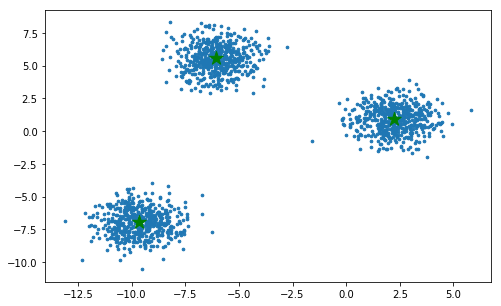

[[[0.0, 0.0], [0.0, 0.0], [-6.061279400200972, 5.528847856450437]], [[-9.72752689276062, -6.937018391038619], [2.1843171998021793, 0.8349173140174869], [0.0, 0.0]], [[-9.566913978231616, -6.9538660408397135], [0.0, 0.0], [-6.007590994342909, 5.66696999840142]], [[0.0, 0.0], [2.2640216007816516, 0.9474185224592113], [0.0, 0.0]]]
[[0, 0, 400], [266, 134, 0], [267, 0, 133], [0, 400, 0]]
num_points in clusters: [533 534 533]


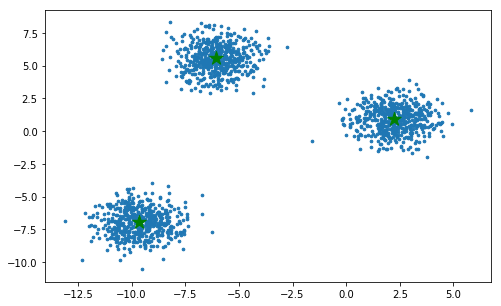

[[[-9.72752689276062, -6.937018391038619], [2.1843171998021793, 0.8349173140174869], [0.0, 0.0]], [[-9.566913978231616, -6.9538660408397135], [0.0, 0.0], [-6.007590994342909, 5.66696999840142]], [[0.0, 0.0], [0.0, 0.0], [-6.061279400200972, 5.528847856450437]], [[0.0, 0.0], [2.2640216007816516, 0.9474185224592113], [0.0, 0.0]]]
[[266, 134, 0], [267, 0, 133], [0, 0, 400], [0, 400, 0]]
num_points in clusters: [533 534 533]


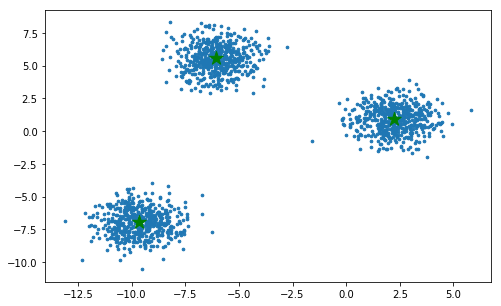

[[[-9.72752689276062, -6.937018391038619], [2.1843171998021793, 0.8349173140174869], [0.0, 0.0]], [[-9.566913978231616, -6.9538660408397135], [0.0, 0.0], [-6.007590994342909, 5.66696999840142]], [[0.0, 0.0], [0.0, 0.0], [-6.061279400200972, 5.528847856450437]], [[0.0, 0.0], [2.2640216007816516, 0.9474185224592113], [0.0, 0.0]]]
[[266, 134, 0], [267, 0, 133], [0, 0, 400], [0, 400, 0]]
num_points in clusters: [533 534 533]


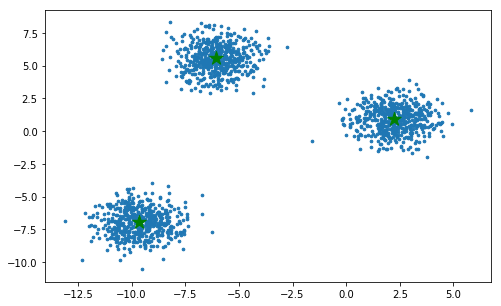

[[[-9.72752689276062, -6.937018391038619], [2.1843171998021793, 0.8349173140174869], [0.0, 0.0]], [[-9.566913978231616, -6.9538660408397135], [0.0, 0.0], [-6.007590994342909, 5.66696999840142]], [[0.0, 0.0], [0.0, 0.0], [-6.061279400200972, 5.528847856450437]], [[0.0, 0.0], [2.2640216007816516, 0.9474185224592113], [0.0, 0.0]]]
[[266, 134, 0], [267, 0, 133], [0, 0, 400], [0, 400, 0]]
num_points in clusters: [533 534 533]


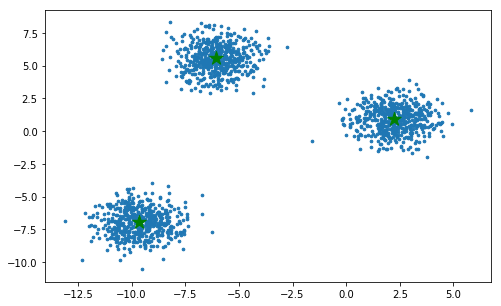

[[[-9.72752689276062, -6.937018391038619], [2.1843171998021793, 0.8349173140174869], [0.0, 0.0]], [[0.0, 0.0], [0.0, 0.0], [-6.061279400200972, 5.528847856450437]], [[-9.566913978231616, -6.9538660408397135], [0.0, 0.0], [-6.007590994342909, 5.66696999840142]], [[0.0, 0.0], [2.2640216007816516, 0.9474185224592113], [0.0, 0.0]]]
[[266, 134, 0], [0, 0, 400], [267, 0, 133], [0, 400, 0]]
num_points in clusters: [533 534 533]


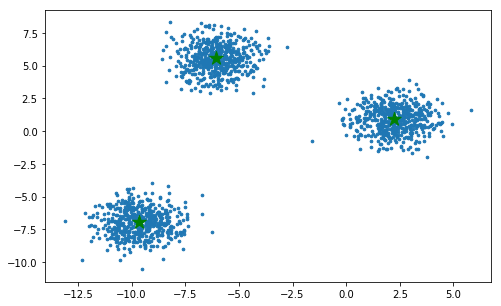

[[[-9.72752689276062, -6.937018391038619], [2.1843171998021793, 0.8349173140174869], [0.0, 0.0]], [[-9.566913978231616, -6.9538660408397135], [0.0, 0.0], [-6.007590994342909, 5.66696999840142]], [[0.0, 0.0], [0.0, 0.0], [-6.061279400200972, 5.528847856450437]], [[0.0, 0.0], [2.2640216007816516, 0.9474185224592113], [0.0, 0.0]]]
[[266, 134, 0], [267, 0, 133], [0, 0, 400], [0, 400, 0]]
num_points in clusters: [533 534 533]


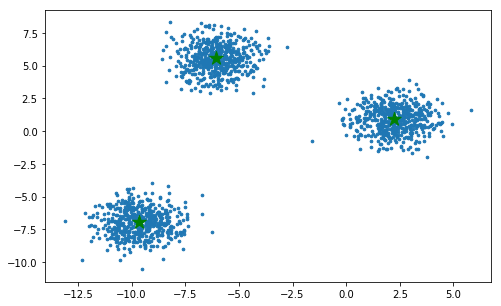

[[[-9.72752689276062, -6.937018391038619], [2.1843171998021793, 0.8349173140174869], [0.0, 0.0]], [[-9.566913978231616, -6.9538660408397135], [0.0, 0.0], [-6.007590994342909, 5.66696999840142]], [[0.0, 0.0], [0.0, 0.0], [-6.061279400200972, 5.528847856450437]], [[0.0, 0.0], [2.2640216007816516, 0.9474185224592113], [0.0, 0.0]]]
[[266, 134, 0], [267, 0, 133], [0, 0, 400], [0, 400, 0]]
num_points in clusters: [533 534 533]


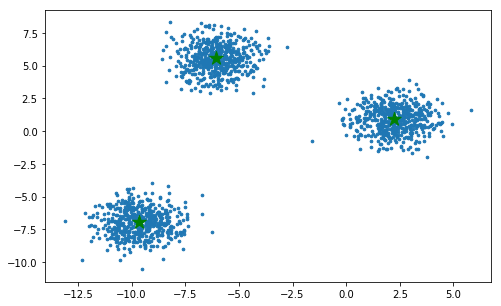

[[[-9.72752689276062, -6.937018391038619], [2.1843171998021793, 0.8349173140174869], [0.0, 0.0]], [[-9.566913978231616, -6.9538660408397135], [0.0, 0.0], [-6.007590994342909, 5.66696999840142]], [[0.0, 0.0], [0.0, 0.0], [-6.061279400200972, 5.528847856450437]], [[0.0, 0.0], [2.2640216007816516, 0.9474185224592113], [0.0, 0.0]]]
[[266, 134, 0], [267, 0, 133], [0, 0, 400], [0, 400, 0]]
num_points in clusters: [533 534 533]


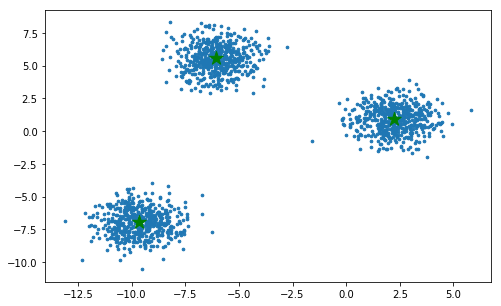

[[[-9.72752689276062, -6.937018391038619], [2.1843171998021793, 0.8349173140174869], [0.0, 0.0]], [[0.0, 0.0], [0.0, 0.0], [-6.061279400200972, 5.528847856450437]], [[-9.566913978231616, -6.9538660408397135], [0.0, 0.0], [-6.007590994342909, 5.66696999840142]], [[0.0, 0.0], [2.2640216007816516, 0.9474185224592113], [0.0, 0.0]]]
[[266, 134, 0], [0, 0, 400], [267, 0, 133], [0, 400, 0]]
num_points in clusters: [533 534 533]


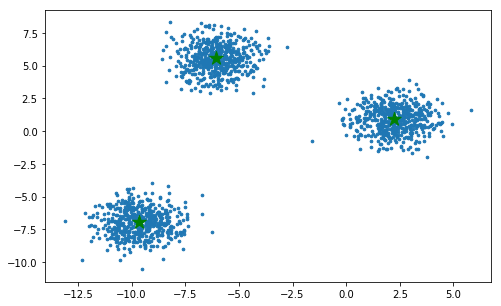

In [19]:
for iter in range(0, n_iter):    
    lazy_partials_EMstep = group(kmeans_tasks.s(task='EM_step', json_dump = json.dumps({'C': C}, cls=NumpyEncoder)) 
                                                   for seq in Xsubseqs)() 
    # call remote workers to run the sort task 
    partials_EMstep = lazy_partials_EMstep.get() # will wait for the tasks to return
    
    #all wrokers are done with their tasks
    partials_C=[json.loads(seq)['C'] for seq in partials_EMstep]
    print(partials_C)
    partials_num_points=[json.loads(seq)['num_points'] for seq in partials_EMstep]
    print(partials_num_points)
    
    #aggregation by th server
    C=np.zeros([n_clusters,n_features])
    for i in range(n_clusters):
        for j in range(n_workers):
             C[i,:]=C[i,:]+partials_num_points[j][i]*np.array(partials_C[j][i])

    num_points=np.sum(np.array(partials_num_points),0)
    print('num_points in clusters:', num_points)
    
    for i in range(n_clusters):
        if num_points[i]>0:
            C[i,:]=C[i,:]/num_points[i]
            
    plt.rcParams['figure.figsize'] = (8, 5)
    fig = plt.figure()
    plt.scatter([actdata['points'][0] for actdata in mydata], [actdata['points'][1] for actdata in mydata], s=7)

    plt.scatter(np.array(C[:,0]), np.array(C[:,1]), marker='*', s=200, c='g')
    plt.show()
